**Mounting Google Drive for Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

**Importing Libraries**

In [ ]:
import os, time, h5py, random, cv2
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from skimage.transform import resize
from sklearn.feature_extraction import image as skimg

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline

**Load NYU2 Dataset Function**

In [ ]:
# Function to Load train dataset from NYU2 Dataset
def load_train_dataset(count = 20, patch_count = 10):
    dataset = '/content/drive/My Drive/DL Project/TrainData/nyu_depth_v2_labeled.mat'
    train_dataset = h5py.File(dataset, "r")

    # Divide image matrix by 255.0 and depth matrix by 4.0 to bring values between 0-1

    trans_vals = [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]

    nyu_image_patches = None
    nyu_haze_patches = None
    nyu_random_transmission = []

    for i in range(count):
        image = train_dataset['images'][i]
        image = (image.transpose(2,1,0))/255.0
        patches = skimg.extract_patches_2d(image, (16, 16), max_patches=patch_count)
        if nyu_image_patches is not None:
            nyu_image_patches = np.concatenate((nyu_image_patches,patches))
        else:
            nyu_image_patches = patches
        
    
    for image in nyu_image_patches:
        transmission = random.choice(trans_vals)
        image = image*transmission+(1-transmission)
        nyu_random_transmission.append(transmission)
        if nyu_haze_patches is not None:
            nyu_haze_patches = np.concatenate((nyu_haze_patches, [image]))
        else:
            nyu_haze_patches = np.array([image])

    train_dataset.close()

    return {"clear_image_patch":nyu_image_patches, "transmission_values":nyu_random_transmission, "haze_image_patch":nyu_haze_patches}

d = load_train_dataset()

**Create Train Dataset using NYU2 Depth Dataset**

In [ ]:
def create_train_dataset(count = 20, patch_count = 10, comp = 9, shuff = True):
  start_time = time.time()
  d = load_train_dataset(count, patch_count)
  print("--- %s seconds in creating dictionary ---" % (time.time() - start_time))
  print("Dictionary created")

  start_time = time.time()
  train_dataset = h5py.File("train_data.hdf5", "w")
  dset = train_dataset.create_dataset("clear_image",data = d["clear_image_patch"],compression=comp,shuffle=shuff)
  dset = train_dataset.create_dataset("transmission_value",data = d["transmission_values"],compression=comp,shuffle=shuff)
  dset = train_dataset.create_dataset("haze_image",data = d["haze_image_patch"],compression=comp,shuffle=shuff)
  train_dataset.close()
  print("--- %s seconds in creating dataset ---" % (time.time() - start_time))
  print("compression:",dset.compression," compression_opt:",dset.compression_opts," shuffle:",dset.shuffle," size:",os.stat("train_data.hdf5").st_size)
  print("Dataset created")  


In [ ]:
create_train_dataset(count = 1200, patch_count = 50)

--- 3156.2790722846985 seconds in creating dictionary ---
Dictionary created
--- 34.50103449821472 seconds in creating dataset ---
compression: gzip  compression_opt: 9  shuffle: True  size: 357870463
Dataset created


**Checking created Dataset**

<KeysViewHDF5 ['clear_image', 'haze_image', 'transmission_value']>


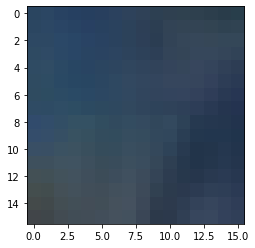

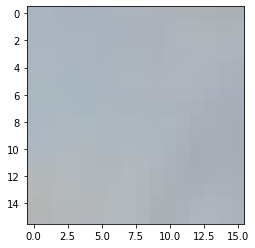

0.4
(60000, 16, 16, 3) (60000, 16, 16, 3) 60000


In [ ]:
temp = h5py.File('train_data.hdf5', 'r')
print(temp.keys())
plt.imshow(temp['clear_image'][1000])
plt.show()
plt.imshow(temp['haze_image'][1000])
plt.show()
print(temp['transmission_value'][1000])
print(temp['clear_image'].shape,temp['haze_image'].shape,len(temp['transmission_value']))
temp.close()

In [ ]:
!cp '/content/train_data.hdf5' '/content/drive/My Drive/DL Project/Datasets/TrainData/train_data_patch_16x16.hdf5'

### Residual Data


In [ ]:
def TransmissionModel(input_shape):
    """
    Implementation of the Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # SLICE Block applied to X
    X1 = Lambda(lambda X: X[:,:,:,:4], name = 'slice1')(X)
    X2 = Lambda(lambda X: X[:,:,:,4:8], name = 'slice2')(X)
    X3 = Lambda(lambda X: X[:,:,:,8:12], name = 'slice3')(X)
    X4 = Lambda(lambda X: X[:,:,:,12:], name = 'slice4')(X)

    # MAXIMUM Block applied to 4 slices
    X = Maximum(name = 'merge1_maximum')([X1,X2,X3,X4])

    # CONV BLock for multi-scale mapping with filters of size 3x3, 5x5, 7x7
    X_3x3 = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', name = 'conv2_3x3')(X)
    X_5x5 = Conv2D(16, (5, 5), strides = (1, 1), padding = 'same', name = 'conv2_5x5')(X)
    X_7x7 = Conv2D(16, (7, 7), strides = (1, 1), padding = 'same', name = 'conv2_7x7')(X)

    # CONCATENATE Block to join 3 multi-scale layers
    X = Concatenate(name = 'merge2_concatenate')([X_3x3,X_5x5,X_7x7])

    # MAXPOOL layer of filter size 7x7
    X = MaxPooling2D((7, 7), strides = (1, 1), name = 'maxpool1')(X)
    
    # CONV -> RELU BLock
    X = Conv2D(1, (8, 8), strides = (1, 1), name = 'conv3')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

def Guidedfilter(im,p,r,eps):
	mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r))
	mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r))
	mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r))
	cov_Ip = mean_Ip - mean_I*mean_p
	mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r))
	var_I   = mean_II - mean_I*mean_I
	a = cov_Ip/(var_I + eps)
	b = mean_p - a*mean_I
	mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r))
	mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r))
	q = mean_a*im + mean_b
	return q

def TransmissionRefine(im,et):
	gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
	gray = np.float64(gray)/255
	r = 60
	eps = 0.0001
	t = Guidedfilter(gray,et,r,eps)
	return t

In [ ]:
file = '/content/drive/My Drive/DL Project/Datasets/TrainData/train_data_patch_16x16.hdf5'
train_dataset = h5py.File(file, 'r')
clean_image = np.array(train_dataset['clear_image'][:])
haze_image = np.array(train_dataset['haze_image'][:])
transmission_value = np.array(train_dataset['transmission_value'])

print ("number of training examples:", clean_image.shape[0])
print ("Clean Image Patch shape:", clean_image.shape)
print ("Haze Image Patch shape:", haze_image.shape)

number of training examples: 60000
Clean Image Patch shape: (60000, 16, 16, 3)
Haze Image Patch shape: (60000, 16, 16, 3)


In [ ]:
tm_model = TransmissionModel((31,31,3))
tm_model.load_weights('transmodel_150_30_weights.h5')
c = np.pad(haze_image,((0,0), (7,8), (7,8), (0,0)), 'symmetric')
nyu_transmission_map = tm_model.predict(c)
b = nyu_transmission_map.reshape(60000,16,16)
d = (haze_image*255.0).astype('uint8')
for i,val in enumerate(b):
    b[i] = TransmissionRefine(d[i],val)
m = nyu_transmission_map.reshape(60000,16,16)

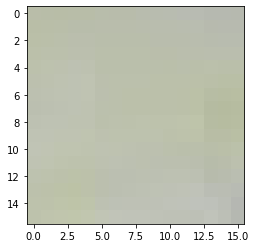

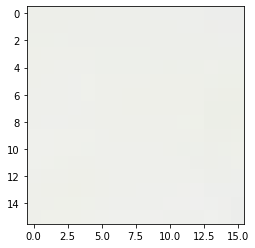

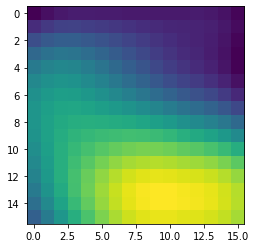

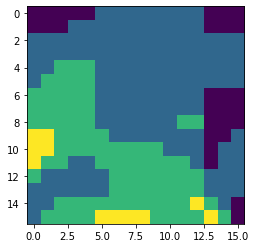

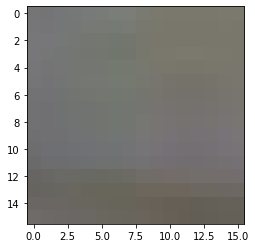

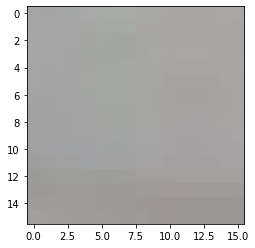

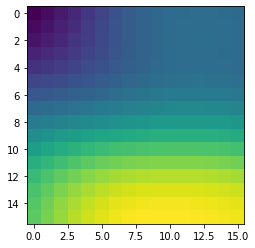

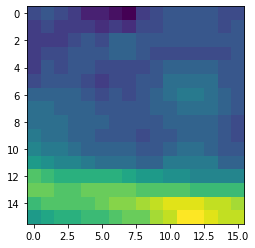

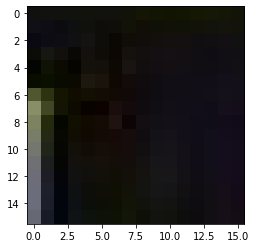

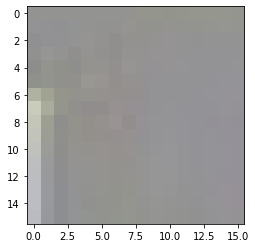

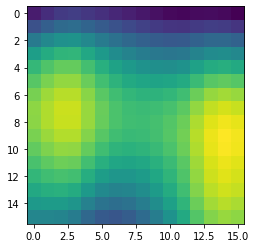

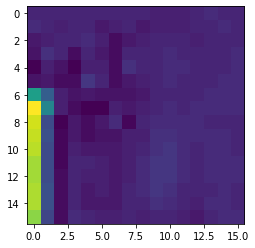

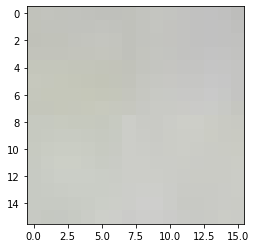

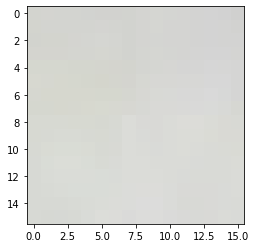

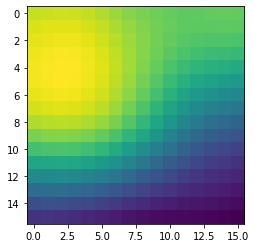

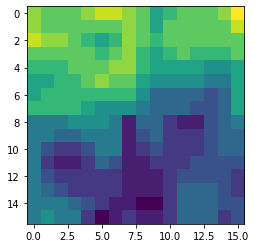

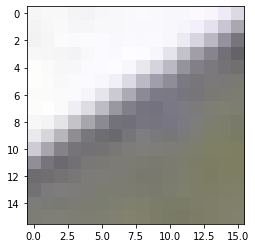

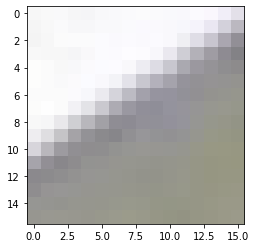

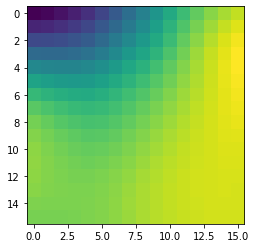

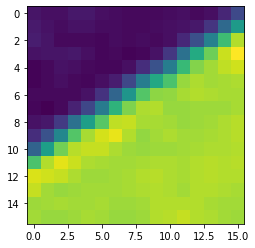

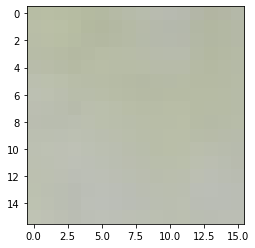

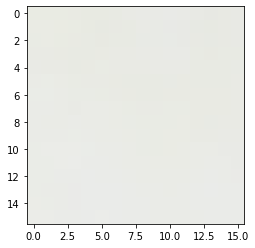

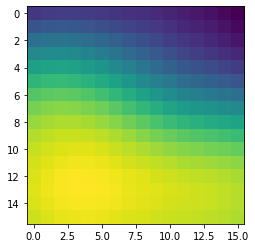

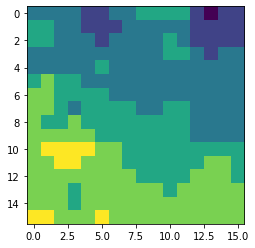

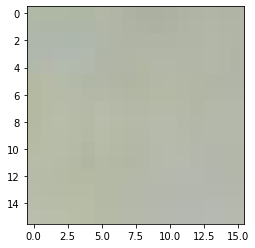

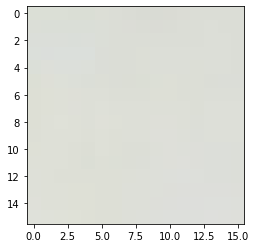

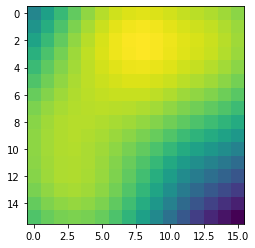

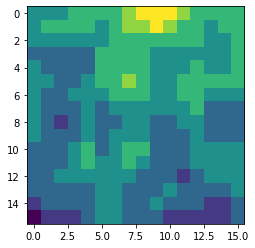

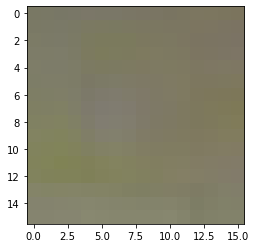

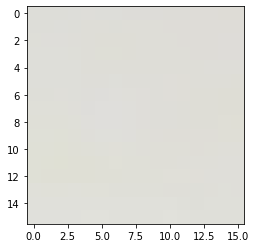

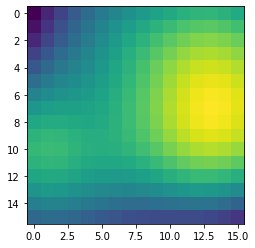

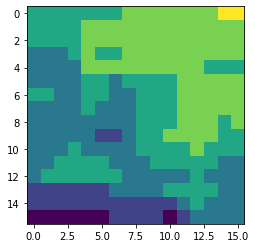

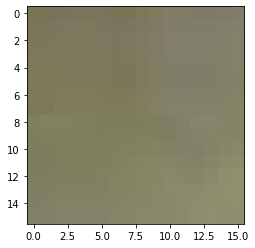

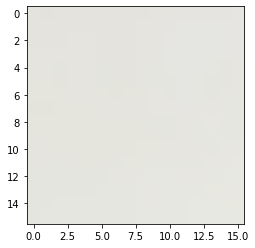

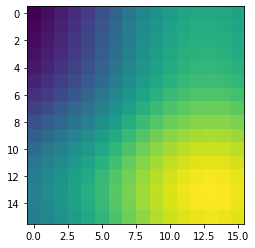

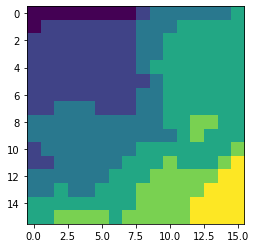

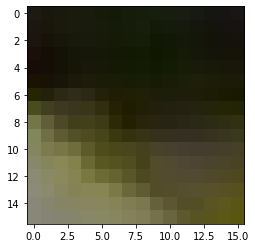

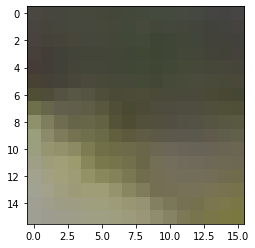

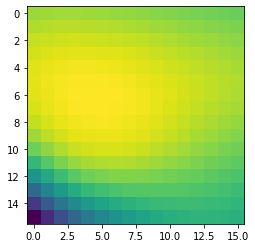

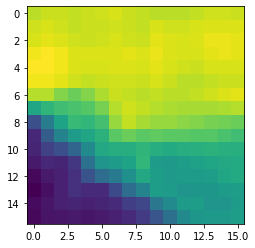

In [ ]:
for i in range(10):
    plt.imshow(clean_image[i])
    plt.show()
    plt.imshow(haze_image[i])
    plt.show()
    plt.imshow(m[i])
    plt.show()
    plt.imshow(b[i])
    plt.show()

In [ ]:
train_dataset = h5py.File("mj.hdf5", "w")
train_dataset.create_dataset("clear_image",data = clean_image,compression=9,shuffle=True)
train_dataset.create_dataset("transmission_map",data = m,compression=9,shuffle=True)
train_dataset.create_dataset("transmission_map_refine",data = b,compression=9,shuffle=True)
train_dataset.create_dataset("haze_image",data = haze_image,compression=9,shuffle=True)
train_dataset.close()